# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
REF_PATH = '/content/drive/MyDrive/Github/11_항공편지연예측'
os.chdir(REF_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [ ]:
# !pip install shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from xgboost import XGBClassifier
from xgboost import plot_importance

import torch
from torch import nn, Tensor
import torch.optim as optim
import torch.nn.functional as F

from tqdm.auto import tqdm

In [36]:
device = 'cuda'

# Load Data

In [ ]:
train_df = pd.read_csv('./data/train.csv')
print(train_df.shape)
train_df.head()

(1000000, 19)


,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,NaN
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,NaN
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,NaN
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,12892,California,EWR,11618,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,NaN
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,14771,California,ACV,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,NaN


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              890985 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         890921 non-null   object 
 13  Distance                  10

# Check the Missing Values

In [ ]:
miss_values = train_df.isnull().sum()
miss_values

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                109015
Destination_Airport              0
Destination_Airport_ID           0
Destination_State           109079
Distance                         0
Airline                     108920
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       744999
dtype: int64

# Feature Importance with XGBoost

In [ ]:
%%time

# NaN을 포함하는 모든 row를 drop
drop_df = train_df.dropna(axis=0).drop(['ID'], axis=1)
print('NaN 제거 : {:,} -> {:,} (제거={:,})'.format(len(train_df),len(drop_df),len(train_df)-len(drop_df)))

# Label Encoding for string data
features = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State',
            'Airline', 'Carrier_Code(IATA)', 'Tail_Number', 'Delay']
for col in features:
    le = LabelEncoder()
    le.fit(drop_df[col])
    drop_df[col] = le.transform(drop_df[col])

    if col == 'Delay':
        print(le.classes_)

# Train XGBoost

X = drop_df.drop('Delay',axis=1)
y = drop_df['Delay']

model = XGBClassifier(eval_metric='logloss')
model.fit(X, y)

NaN 제거 : 1,000,000 -> 113,787 (제거=886,213)
['Delayed' 'Not_Delayed']
CPU times: user 23.7 s, sys: 24.8 ms, total: 23.7 s
Wall time: 15 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

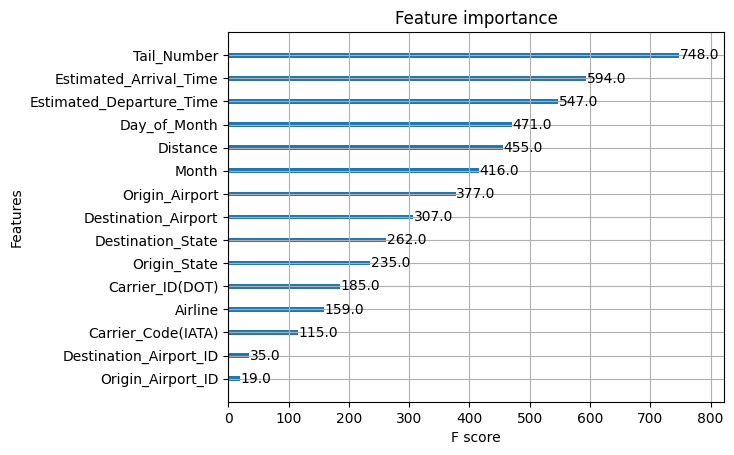

In [ ]:
plot_importance(model)
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


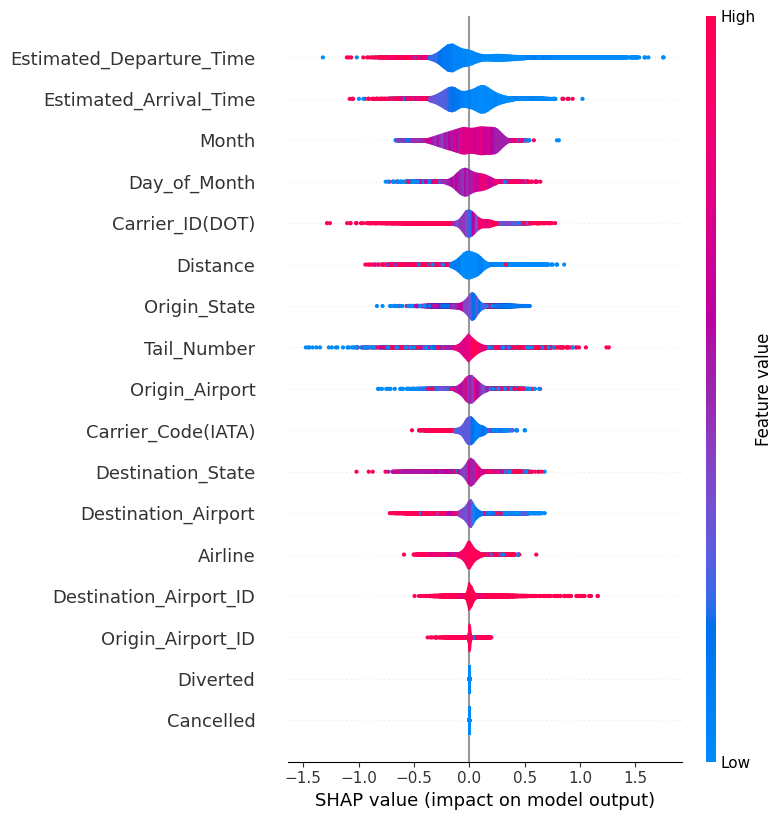

CPU times: user 2min 53s, sys: 2.55 s, total: 2min 56s
Wall time: 2min 11s


In [ ]:
%%time
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type='violin')

# Proportion of Labeled Data / Unlabeled Data

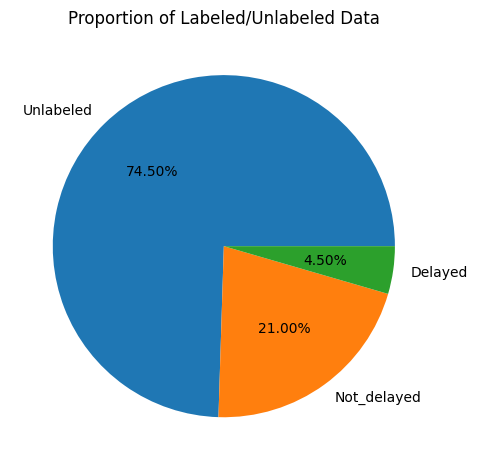

In [ ]:
unlabeled_delay_value = train_df.Delay.isnull().sum()

not_delay_value = train_df.loc[train_df.Delay == 'Not_Delayed'].shape[0]
delay_value = train_df.loc[train_df.Delay == 'Delayed'].shape[0]

labels = ['Unlabeled', 'Not_delayed', 'Delayed']
sizes = [unlabeled_delay_value, not_delay_value, delay_value]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.2f%%')
ax.set_title('Proportion of Labeled/Unlabeled Data')
plt.tight_layout()

# Iterative Imputation for Departure/Arrival Time Feature
- [Imputation 참조](https://velog.io/@jee-9/%EA%B2%B0%EC%B8%A1%EC%B9%98Nulls-%EC%B2%98%EB%A6%AC%EC%97%90-%EB%8C%80%ED%95%B4%EC%84%9C-Imputation-Single-MICE)

In [30]:
%%time

# Numeric feature only
drop_columns = ['ID', 'Origin_State', 'Destination_State', 'Airline', 'Carrier_Code(IATA)', 'Carrier_ID(DOT)', 'Origin_Airport', 'Destination_Airport', 'Tail_Number', 'Delay']
train_feature = train_df.drop(drop_columns, axis=1)
display(train_df[drop_columns].apply(lambda x: x.nunique()))

imputer = IterativeImputer(max_iter=500,random_state=42)
imputed_feature = imputer.fit_transform(train_feature)

imputed_feature = pd.DataFrame(imputed_feature, columns=train_feature.columns) # imputed features

ID                     1000000
Origin_State                52
Destination_State           52
Airline                     28
Carrier_Code(IATA)          11
Carrier_ID(DOT)             28
Origin_Airport             374
Destination_Airport        375
Tail_Number               6430
Delay                        2
dtype: int64

CPU times: user 13.6 s, sys: 9.19 s, total: 22.8 s
Wall time: 15 s


In [31]:
imputed_feature.shape

(1000000, 9)

In [34]:
display(train_df.drop(drop_columns,axis=1).head())
display(imputed_feature.head())

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance
0,4,15,NaN,NaN,0,0,13851,12191,419.0
1,8,15,740.0,1024.0,0,0,13930,14869,1250.0
2,9,6,1610.0,1805.0,0,0,11057,12953,544.0
3,7,10,905.0,1735.0,0,0,12892,11618,2454.0
4,1,11,900.0,1019.0,0,0,14771,10157,250.0


,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance
0,4.0,15.0,1333.469563,1486.207808,0.0,0.0,13851.0,12191.0,419.0
1,8.0,15.0,740.000000,1024.000000,0.0,0.0,13930.0,14869.0,1250.0
2,9.0,6.0,1610.000000,1805.000000,0.0,0.0,11057.0,12953.0,544.0
3,7.0,10.0,905.000000,1735.000000,0.0,0.0,12892.0,11618.0,2454.0
4,1.0,11.0,900.000000,1019.000000,0.0,0.0,14771.0,10157.0,250.0


In [35]:
imputed_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Month                     1000000 non-null  float64
 1   Day_of_Month              1000000 non-null  float64
 2   Estimated_Departure_Time  1000000 non-null  float64
 3   Estimated_Arrival_Time    1000000 non-null  float64
 4   Cancelled                 1000000 non-null  float64
 5   Diverted                  1000000 non-null  float64
 6   Origin_Airport_ID         1000000 non-null  float64
 7   Destination_Airport_ID    1000000 non-null  float64
 8   Distance                  1000000 non-null  float64
dtypes: float64(9)
memory usage: 68.7 MB


# Preparing Train Data

In [37]:
target_df = [train_df[data] for data in ['Origin_Airport', 'Destination_Airport', 'Tail_Number', 'Delay']]
target_df.insert(0, imputed_feature)
final_df = pd.concat(target_df, axis=1)

In [39]:
final_df.head()

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Origin_Airport,Destination_Airport,Tail_Number,Delay
0,4.0,15.0,1333.469563,1486.207808,0.0,0.0,13851.0,12191.0,419.0,OKC,HOU,N7858A,NaN
1,8.0,15.0,740.000000,1024.000000,0.0,0.0,13930.0,14869.0,1250.0,ORD,SLC,N125SY,NaN
2,9.0,6.0,1610.000000,1805.000000,0.0,0.0,11057.0,12953.0,544.0,CLT,LGA,N103US,NaN
3,7.0,10.0,905.000000,1735.000000,0.0,0.0,12892.0,11618.0,2454.0,LAX,EWR,N595UA,NaN
4,1.0,11.0,900.000000,1019.000000,0.0,0.0,14771.0,10157.0,250.0,SFO,ACV,N161SY,NaN


## Label Encdoing in Categorical Features

In [ ]:
# Label Encoding for string data
for c in ['Origin_Airport', 'Destination_Airport', 'Tail_Number']:
    le = LabelEncoder()
    le.fit(final_df[c])
    final_df[c] = le.transform(final_df[c])

In [ ]:
print(f'max_value of Origin_Airport: {final_df.Origin_Airport.max()}')
print(f'max_value of Destination_Airport: {final_df.Destination_Airport.max()}')
print(f'max_value of Tail_Number: {final_df.Tail_Number.max()}')

max_value of Origin_Airport: 373
max_value of Destination_Airport: 374
max_value of Tail_Number: 6429


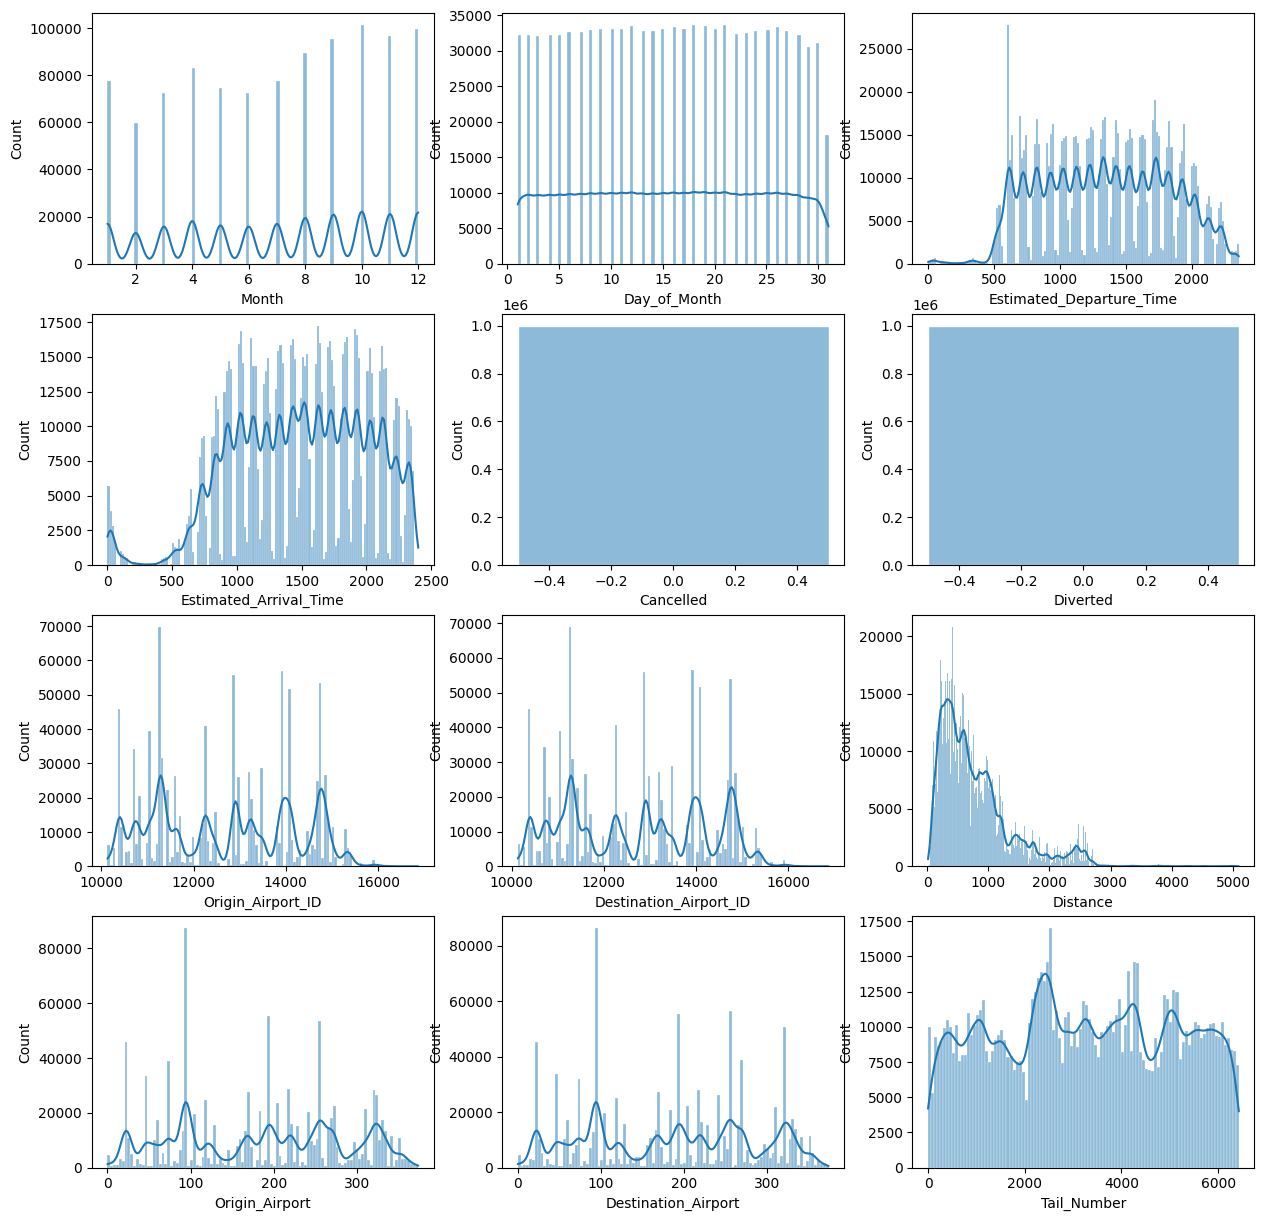

CPU times: user 46.3 s, sys: 1.58 s, total: 47.9 s
Wall time: 52.4 s


In [ ]:
%%time

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
sns.set_theme(style='whitegrid')

col_name = final_df.columns.values.tolist()

index = 0
for row in range(4):
    for col in range(3):
        sns.histplot(data=final_df, x=col_name[index], kde=True, ax=axes[row, col])
        index += 1

plt.show()

## Z-score Normalization

In [ ]:
pd.set_option('mode.chained_assignment', None) # Ignore SettingWithCopyWarning

# z-score normalization
aimed_col = ['Month', 'Day_of_Month', 'Estimated_Departure_Time', 'Estimated_Arrival_Time', 'Origin_Airport_ID', 'Destination_Airport_ID', 'Distance', 'Origin_Airport', 'Destination_Airport', 'Tail_Number']
for col in aimed_col:
    final_df[col] = (final_df[col] - final_df[col].mean()) / final_df[col].std()

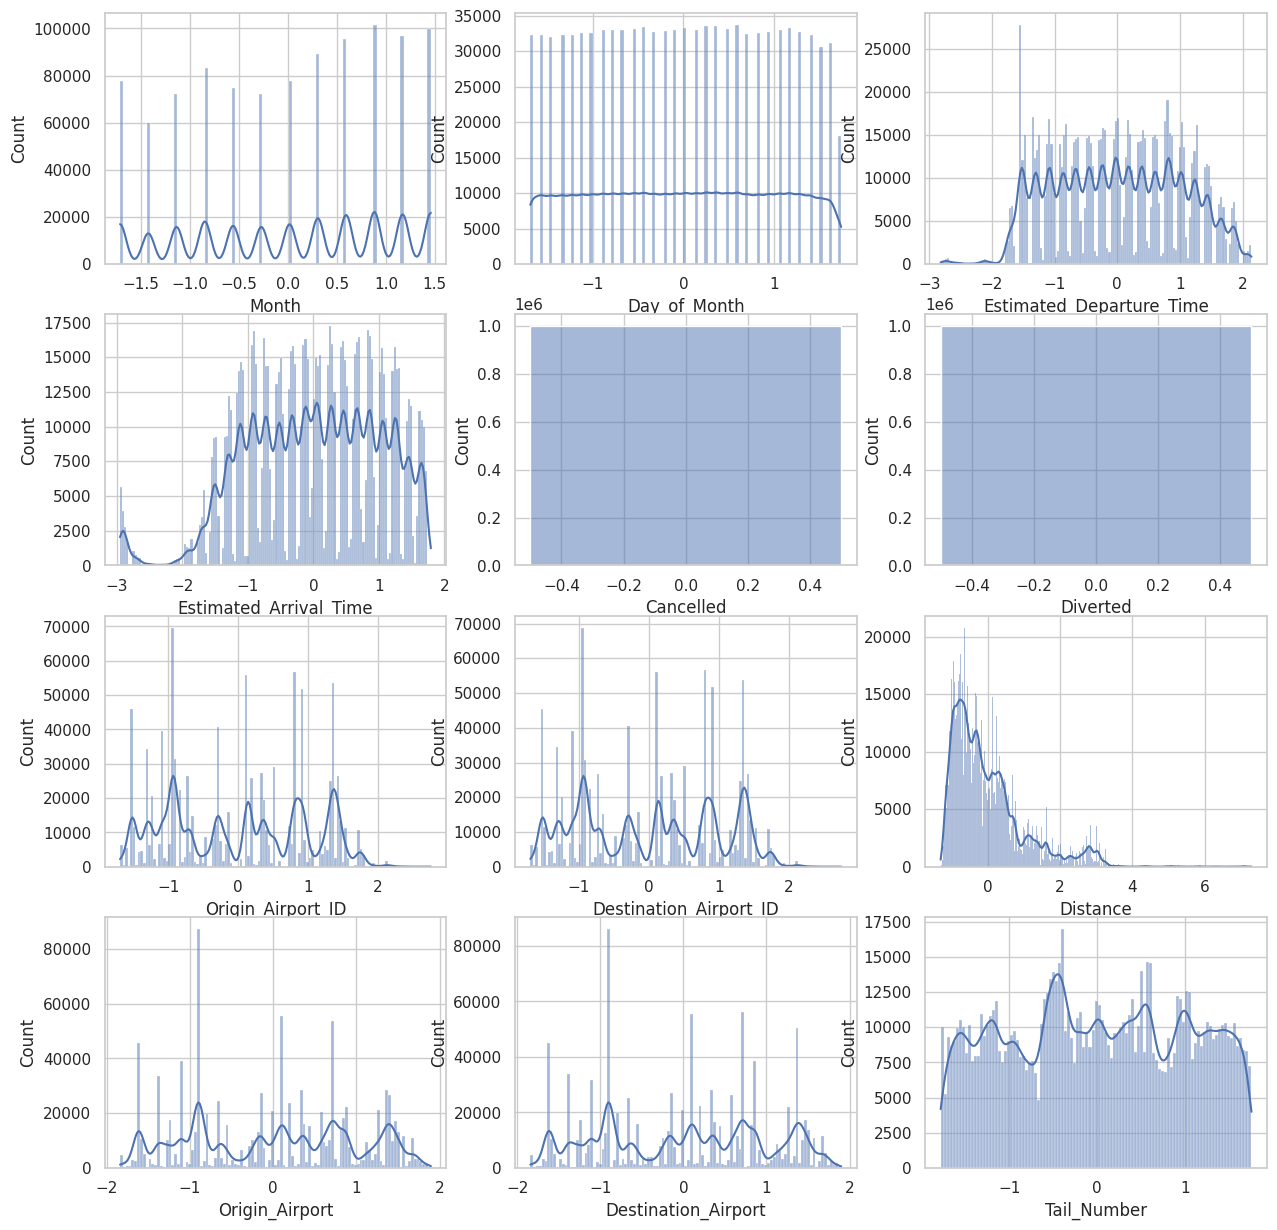

CPU times: user 43.7 s, sys: 1.66 s, total: 45.4 s
Wall time: 45.3 s


In [ ]:
%%time

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
sns.set_theme(style='whitegrid')

col_name = final_df.columns.values.tolist()

index = 0
for row in range(4):
    for col in range(3):
        sns.histplot(data=final_df, x=col_name[index], kde=True, ax=axes[row, col])
        index += 1

plt.show()

In [ ]:
final_df.head(3)

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Origin_Airport,Destination_Airport,Tail_Number,Delay
0,-0.850585,-0.087276,-0.015940,-0.013746,0.0,0.0,0.762223,-0.337124,-0.617949,0.682733,-0.251234,0.598670,NaN
1,0.304648,-0.087276,-1.263951,-0.928092,0.0,0.0,0.814371,1.430285,0.788641,0.722746,1.469016,-1.610785,NaN
2,0.593456,-1.114261,0.565577,0.616893,0.0,0.0,-1.082076,0.165776,-0.406368,-1.097855,0.198831,-1.704476,NaN


In [ ]:
ul_df = final_df.loc[final_df.Delay.isnull()].drop(['Delay'], axis=1)
l_df = final_df.loc[final_df.Delay.notnull()]

le = LabelEncoder()
le.fit(l_df['Delay'])
l_df['Delay'] = le.transform(l_df['Delay'])

l_x = torch.tensor(l_df.iloc[:, :-1].values).type(torch.float32).to(device)
l_y = torch.tensor(l_df['Delay'].values).type(torch.float32).to(device)
u_x = torch.tensor(ul_df.values).type(torch.float32).to(device)

print(le.classes_)

['Delayed' 'Not_Delayed']


In [ ]:
print(f'{l_x.dtype} / {l_y.dtype} / {u_x.dtype}')

torch.float32 / torch.float32 / torch.float32


Delayed: 0 / Not_Delayed: 1

# Define model

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, d_columns, d_model=128, dropout=0.2):
        super().__init__()

        self.ff_activation = nn.ReLU()
        self.ff_batchnorm = nn.BatchNorm1d(d_model)

        self.ff_1 = nn.Linear(d_columns, d_model)
        self.ff_2 = nn.Linear(d_model, d_model)
        self.ff_3 = nn.Linear(d_model, d_model)
        self.ff_4 = nn.Linear(d_model, d_model)
        self.ff_5 = nn.Linear(d_model, d_model)

        self.classification = nn.Sequential(
            nn.Linear(d_model, int(d_model/2)),
            nn.BatchNorm1d(int(d_model/2)),
            nn.Dropout(p=dropout),
            nn.GELU(),
            nn.Linear(int(d_model/2), int(d_model/4)),
            nn.BatchNorm1d(int(d_model/4)),
            nn.Dropout(p=dropout),
            nn.GELU(),
            nn.Linear(int(d_model/4), 1), # for binary classification
        )

    def forward(self, x):
        x1 = self.ff_1(x)
        x1 = self.ff_batchnorm(x1)
        x1 = self.ff_activation(x1)

        x2 = self.ff_2(x1)
        x2 = self.ff_batchnorm(x2)
        x2 = self.ff_activation(x2)

        x3 = self.ff_3(torch.add(x1,x2))
        x3 = self.ff_batchnorm(x3)
        x3 = self.ff_activation(x3)

        x4 = self.ff_4(x3)
        x4 = self.ff_batchnorm(x4)
        x4 = self.ff_activation(x4)

        x5 = self.ff_5(torch.add(x3,x4))
        x5 = self.ff_batchnorm(x5)
        x5 = self.ff_activation(x5)

        logits = self.classification(x5)
        return F.sigmoid(logits).view(-1)

class CustomLoss(nn.Module):
    def __init__(self, xi):
        super(CustomLoss, self).__init__()
        self.xi = xi

    def forward(self, output, target):
        return torch.mean(-1.0*((1-self.xi)*target*torch.log(output) + self.xi*(1-target)*torch.log(1-output)))

# Define Training Process

In [ ]:
teacher = BaseModel(d_columns=12).to(device)
student = BaseModel(d_columns=12).to(device)

t_optimizer = optim.SGD(teacher.parameters(),lr=0.0001, momentum=0.9)
s_optimizer = optim.SGD(student.parameters(),lr=0.0001, momentum=0.9)

criterion = CustomLoss(xi=0.725)
best_loss = np.inf
patient = 0

early_stop_epoch = 0
tl_loss, sl_loss = [], []
for epochs in tqdm(range(5000)):
    teacher.train()
    student.train()

    t_optimizer.zero_grad()
    s_optimizer.zero_grad()

    s_l_pred = student(l_x)
    s_l_loss = criterion(s_l_pred, l_y)

    sl_loss.append(s_l_loss.item())

    t_u_pred = teacher(u_x)
    pseudo_y = (t_u_pred >= torch.FloatTensor([0.5]).to(device)).type(torch.float32)

    s_u_pred = student(u_x)
    s_u_loss = criterion(s_u_pred, pseudo_y)
    s_u_loss.backward()
    s_optimizer.step()

    s_l_pred_new = student(l_x)
    s_l_loss_new = criterion(s_l_pred_new, l_y)
    change = s_l_loss_new - s_l_loss

    t_l_pred = teacher(l_x)
    t_l_loss = criterion(t_l_pred, l_y)

    tl_loss.append(t_l_loss.item())

    t_mpl_loss = change * criterion(t_u_pred, pseudo_y)

    (t_l_loss + t_mpl_loss).backward()
    t_optimizer.step()

#    if epochs+1 >= 250 and best_loss > s_l_loss.item():
#        best_loss = s_l_loss.item()
#        patient = 0
#    elif epochs+1 >= 250 and best_loss <= s_l_loss.item():
#        patient += 1
#
#    if patient == 20:
#        early_stop_epoch = epochs + 1
#
#        torch.save(teacher.state_dict(), root_path+'/models/teacher/es_ratio_loss_teacher_state_dict.pt')
#        torch.save(student.state_dict(), root_path+'/models/student/es_ratio_loss_student_state_dict.pt')

  0%|          | 0/5000 [00:00<?, ?it/s]

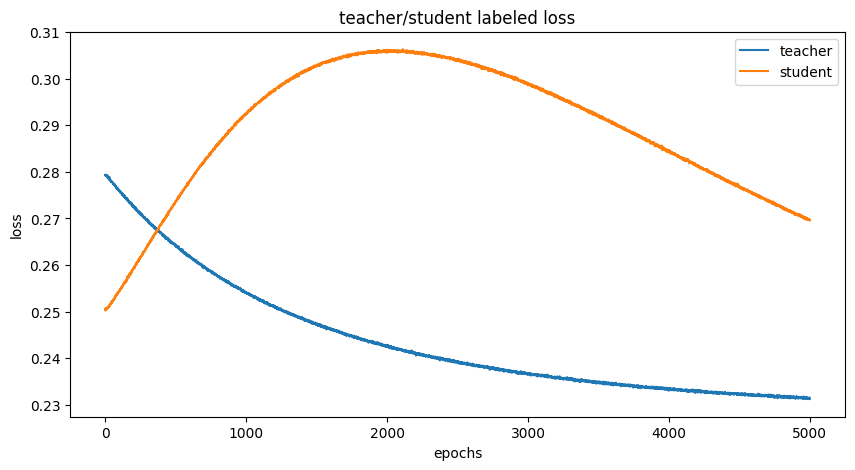

In [ ]:
x = np.linspace(0, 5000, 5000)

plt.figure(figsize=(10, 5))
plt.plot(x, tl_loss, label='teacher')
plt.plot(x, sl_loss, label='student')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('teacher/student labeled loss')
if early_stop_epoch:
    plt.axvline(early_stop_epoch, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.legend()
plt.show()

# Save Model

In [ ]:
torch.save(teacher.state_dict(), root_path+'/models/teacher/725_ratio_loss_many_epochs_teacher_state_dict.pt')
torch.save(student.state_dict(), root_path+'/models/student/725_ratio_loss_many_epochs_student_state_dict.pt')

# Load Model

In [ ]:
root_path = '/content/drive/MyDrive/dacon/delay_airplane'

student_trained = BaseModel(d_columns=12).cuda()
student_trained.load_state_dict(torch.load(root_path+'/models/student/725_ratio_loss_many_epochs_student_state_dict.pt'))
student_trained.eval()

BaseModel(
  (ff_activation): ReLU()
  (ff_batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ff_1): Linear(in_features=12, out_features=128, bias=True)
  (ff_2): Linear(in_features=128, out_features=128, bias=True)
  (ff_3): Linear(in_features=128, out_features=128, bias=True)
  (ff_4): Linear(in_features=128, out_features=128, bias=True)
  (ff_5): Linear(in_features=128, out_features=128, bias=True)
  (classification): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): GELU(approximate='none')
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): GELU(approximate='none')
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

# Preparing Test Data

In [ ]:
test_df = pd.read_csv(root_path+'/data/test.csv')

drop_columns = ['ID', 'Origin_State', 'Destination_State', 'Airline', 'Carrier_Code(IATA)', 'Carrier_ID(DOT)', 'Origin_Airport', 'Destination_Airport', 'Tail_Number']
train_feature = test_df.drop(drop_columns, axis=1)

imputer = IterativeImputer(random_state=42)
imputed_feature = imputer.fit_transform(train_feature)

imputed_feature = pd.DataFrame(imputed_feature, columns=train_feature.columns) # imputed features

target_df = [test_df[data] for data in ['Origin_Airport', 'Destination_Airport', 'Tail_Number']]
target_df.insert(0, imputed_feature)
final_df = pd.concat(target_df, axis=1)

# Label Encoding for string data
for c in ['Origin_Airport', 'Destination_Airport', 'Tail_Number']:
    le = LabelEncoder()
    le.fit(final_df[c])
    final_df[c] = le.transform(final_df[c])

pd.set_option('mode.chained_assignment', None) # Ignore SettingWithCopyWarning

# z-score normalization
aimed_col = ['Month', 'Day_of_Month', 'Estimated_Departure_Time', 'Estimated_Arrival_Time', 'Origin_Airport_ID', 'Destination_Airport_ID', 'Distance', 'Origin_Airport', 'Destination_Airport', 'Tail_Number']
for col in aimed_col:
    final_df[col] = (final_df[col] - final_df[col].mean()) / final_df[col].std()

test_x = torch.tensor(final_df.values).type(torch.float32).cuda()

In [ ]:
final_df.head(3)

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Origin_Airport,Destination_Airport,Tail_Number
0,1.526254,0.044898,-0.468430,-0.342468,0.0,0.0,-0.279590,1.311013,-1.017307,-0.139317,1.264011,0.638707
1,0.663277,-0.414529,0.260294,0.376967,0.0,0.0,-0.708928,-1.521945,-0.083842,-0.636777,-1.622434,-0.708686
2,-1.062675,-1.103671,0.472132,0.767983,0.0,0.0,0.822908,0.167518,-0.105707,0.726263,0.199012,-0.591000


# Inference

In [ ]:
pred_test = student_trained(test_x)

In [ ]:
proba_ndelayed = pred_test.cpu().data.numpy().reshape(-1,1)
proba_delayed = 1 - proba_ndelayed

print(proba_ndelayed.shape)

(1000000, 1)


In [ ]:
final_pred = np.concatenate((proba_ndelayed, proba_delayed), axis=1)
print(final_pred.shape)

(1000000, 2)


In [ ]:
sample_submission = pd.read_csv(root_path+'/data/sample_submission.csv', index_col = 0)
submission = pd.DataFrame(data=final_pred, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv(root_path+'/725_ratio_submission.csv', index=True)